<a href="https://colab.research.google.com/github/manju2021/cxr_images/blob/master/cxr_imageprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pip install plot_utils

In [ ]:
import os
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
#import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
# Lets try augmenting a cifar10 image using these techniques
from skimage import data, img_as_float
from skimage import exposure
from tensorflow.keras.layers import Dense,BatchNormalization,Reshape,Conv2DTranspose,Conv2D,LeakyReLU,Dropout,Flatten
import matplotlib.pyplot as plt
import keras_ocr
import cv2
import math
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.image as mpimg

Tensorflow version: 2.4.0


In [ ]:
#clone the dataset from the github repository
#! git clone https://github.com/education454/datasets.git

Cloning into 'datasets'...
remote: Enumerating objects: 2301, done.
remote: Total 2301 (delta 0), reused 0 (delta 0), pack-reused 2301
Receiving objects: 100% (2301/2301), 1.31 GiB | 22.83 MiB/s, done.
Checking out files: 100% (2295/2295), done.


In [ ]:
#set the path to the main dir
main_dir=r"C:\Users\manju\Desktop\upgrad\MS\Research Project\datasets-master\datasets-master\Data" 
#set the path to the train dir
train_dir=os.path.join(main_dir,'train')
#set the path to the test dir
test_dir=os.path.join(main_dir,'test')

#directory with the training covid images
train_covid_dir=os.path.join(train_dir,"COVID19")
#directory with the training normal images
train_normal_dir=os.path.join(train_dir,"NORMAL")
#directory with the testing covid images
test_covid_dir=os.path.join(test_dir,"COVID19")
#directory with the testing normal images
test_normal_dir=os.path.join(test_dir,"NORMAL")

In [ ]:
#print the filenames
train_covid_names=os.listdir(train_covid_dir)
print(train_covid_names[1:10])
train_normal_names=os.listdir(train_normal_dir)
print(train_normal_names[1:10])
test_covid_names=os.listdir(test_covid_dir)
print(test_covid_names[1:10])
test_normal_names=os.listdir(test_normal_dir)
print(test_normal_names[1:10])

['COVID-19 (1).png', 'COVID-19 (10).jpeg', 'COVID-19 (101).jpg', 'COVID-19 (107).jpg', 'COVID-19 (11).jpeg', 'COVID-19 (11).jpg', 'COVID-19 (12).jpeg', 'COVID-19 (12).jpg', 'COVID-19 (13).jpeg']
['NORMAL(1).jpg', 'NORMAL(100).jpg', 'NORMAL(1000).jpg', 'NORMAL(1002).jpg', 'NORMAL(1005).jpg', 'NORMAL(1006).jpg', 'NORMAL(1007).jpg', 'NORMAL(1008).jpg', 'NORMAL(1009).jpg']
['COVID-19 (353).jpg', 'COVID-19 (371).jpg', 'COVID-19 (425).jpg', 'COVID-19 (439).jpg', 'COVID-19 (457).jpg', 'COVID-19 (461).jpg', 'COVID-19 (475).jpg', 'COVID-19 (479).jpg', 'COVID-19 (485).jpg']
['NORMAL(1001).jpg', 'NORMAL(1003).jpg', 'NORMAL(1004).jpg', 'NORMAL(1011).jpg', 'NORMAL(1012).jpg', 'NORMAL(1015).jpg', 'NORMAL(1017).jpg', 'NORMAL(1020).jpg', 'NORMAL(1022).jpg']


In [ ]:
#print the total no of images present in each dir
print("Total images present in the training set :",len(train_covid_names+train_normal_names))
print("Total images present in the test set :",len(test_covid_names+test_normal_names))

Total images present in the training set : 1811
Total images present in the test set : 484


['C:\\Users\\manju\\Desktop\\upgrad\\MS\\Research Project\\datasets-master\\datasets-master\\Data\\train\\COVID19\\COVID-19 (1).jpeg', 'C:\\Users\\manju\\Desktop\\upgrad\\MS\\Research Project\\datasets-master\\datasets-master\\Data\\train\\COVID19\\COVID-19 (1).png', 'C:\\Users\\manju\\Desktop\\upgrad\\MS\\Research Project\\datasets-master\\datasets-master\\Data\\train\\COVID19\\COVID-19 (10).jpeg', 'C:\\Users\\manju\\Desktop\\upgrad\\MS\\Research Project\\datasets-master\\datasets-master\\Data\\train\\COVID19\\COVID-19 (101).jpg', 'C:\\Users\\manju\\Desktop\\upgrad\\MS\\Research Project\\datasets-master\\datasets-master\\Data\\train\\COVID19\\COVID-19 (107).jpg', 'C:\\Users\\manju\\Desktop\\upgrad\\MS\\Research Project\\datasets-master\\datasets-master\\Data\\train\\COVID19\\COVID-19 (11).jpeg', 'C:\\Users\\manju\\Desktop\\upgrad\\MS\\Research Project\\datasets-master\\datasets-master\\Data\\train\\COVID19\\COVID-19 (11).jpg', 'C:\\Users\\manju\\Desktop\\upgrad\\MS\\Research Project\\

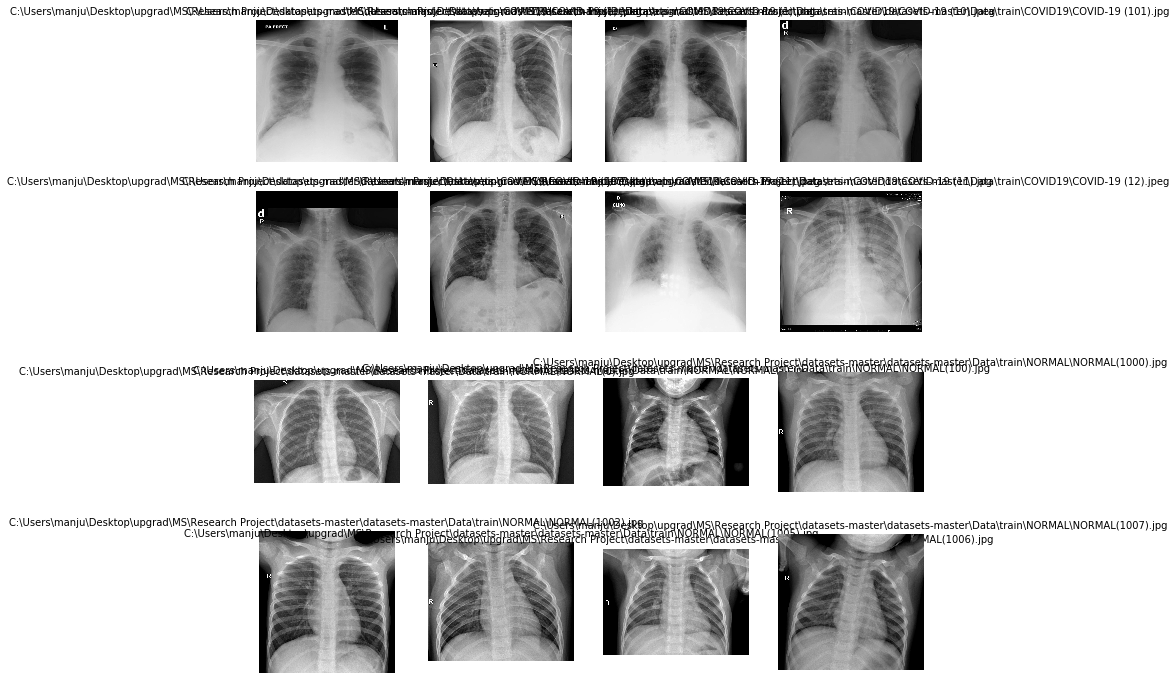

In [ ]:
# plot a grid of 16 images (8 images of Covid19 and 8 images of Normal)
import matplotlib.image as mpimg
#set the number of columns and rows
rows=4
cols=4
#set the figure size
fig=plt.gcf()
fig.set_size_inches(12,12)
#get the filenames from the covid & normal dir of the train dataset
covid_pic=[os.path.join(train_covid_dir,filename) for filename in train_covid_names[0:8]]
normal_pic=[os.path.join(train_normal_dir,filename) for filename in train_normal_names[0:8]]
#print the list
print(covid_pic)
print(normal_pic)
#merge the covid and normal list
merged_list=covid_pic+normal_pic
for i,img_path in enumerate(merged_list):
  data=img_path
  sp=plt.subplot(rows,cols,i+1)
  sp.axis('Off')
  img=mpimg.imread(img_path)
  sp.set_title(data,fontsize=10)
  plt.imshow(img,cmap='gray')
plt.show()



In [ ]:
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)

#https://towardsdatascience.com/remove-text-from-images-using-cv2-and-keras-ocr-24e7612ae4f4
def inpaint_text(img_path, pipeline):
    # read image
    img = keras_ocr.tools.read(img_path)
    # generate (word, box) tuples 
    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    
    if len(prediction_groups)>0:
        for box in prediction_groups[0]:
            x0, y0 = box[1][0]
            x1, y1 = box[1][1] 
            x2, y2 = box[1][2]
            x3, y3 = box[1][3] 

            x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
            x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)

            thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))

            cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
            thickness)
            img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
    else:
        img=img
        #Do the horizontal flipping of the image
    img_flip_lr = cv2.flip(img, 1)

    #Change the contrast intensity of the image 
    img_adapteq = exposure.equalize_adapthist(img_flip_lr, clip_limit=0.03)

    #CLAHE is a variant of Adaptive histogram equalization (AHE) which takes care of over-amplification of the contrast. CLAHE operates on small regions in the image, called tiles, rather than the entire image. ... This algorithm can be applied to improve the contrast of images.
    #save the updated image to the destination folder
    #Rescale the image 
    resized = cv2.resize(img_adapteq, (256,256), interpolation = cv2.INTER_AREA)
                 
    return(resized)

In [ ]:
#image_path=r'C:\Users\manju\Desktop\upgrad\MS\Research Project\datasets-master\datasets-master\Data\train\COVID19\COVID19(517).JPG'
pipeline = keras_ocr.pipeline.Pipeline()

directory=r'C:\Users\manju\Desktop\upgrad\MS\Research Project\testing_pytesereact\aug_image\Covid19'
os.chdir(directory)

covid_pic=[os.path.join(train_covid_dir,filename) for filename in train_covid_names]
for i,img_path in enumerate(covid_pic):
    test_image=inpaint_text(img_path, pipeline)
    img = test_image
    min_val,max_val=img.min(),img.max()
    img = 255.0*(img - min_val)/(max_val - min_val)
    #img = img.astype(np.uint8)
    filename='aug_'+train_covid_names[i]
    cv2.imwrite(filename,img)
    print('Saved the file',filename) 

Looking for C:\Users\manju\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\manju\.keras-ocr\crnn_kurapan.h5
Saved the file aug_COVID-19 (1).jpeg
Saved the file aug_COVID-19 (1).png
Saved the file aug_COVID-19 (10).jpeg
Saved the file aug_COVID-19 (101).jpg
Saved the file aug_COVID-19 (107).jpg
Saved the file aug_COVID-19 (11).jpeg
Saved the file aug_COVID-19 (11).jpg
Saved the file aug_COVID-19 (12).jpeg
Saved the file aug_COVID-19 (12).jpg
Saved the file aug_COVID-19 (13).jpeg
Saved the file aug_COVID-19 (14).jpeg
Saved the file aug_COVID-19 (15).jpeg
Saved the file aug_COVID-19 (15).jpg
Saved the file aug_COVID-19 (151).jpg
Saved the file aug_COVID-19 (155).jpg
Saved the file aug_COVID-19 (156).jpg
Saved the file aug_COVID-19 (159).jpg
Saved the file aug_COVID-19 (16).jpg
Saved the file aug_COVID-19 (160).jpg
Saved the file aug_COVID-19 (161).jpg
Saved the file aug_COVID-19 (162).jpg
Saved the file aug_COVID-19 (168).jpg
Saved the file aug_COVID-19 (169).jpg
Saved the file aug_COVID

Saved the file aug_COVID19(228).jpg
Saved the file aug_COVID19(229).jpg
Saved the file aug_COVID19(23).jpg
Saved the file aug_COVID19(230).jpg
Saved the file aug_COVID19(231).jpg
Saved the file aug_COVID19(232).jpg
Saved the file aug_COVID19(233).jpg
Saved the file aug_COVID19(234).jpg
Saved the file aug_COVID19(235).jpg
Saved the file aug_COVID19(236).jpg
Saved the file aug_COVID19(237).jpg
Saved the file aug_COVID19(238).jpg
Saved the file aug_COVID19(239).jpg
Saved the file aug_COVID19(24).jpg
Saved the file aug_COVID19(240).jpg
Saved the file aug_COVID19(241).jpg
Saved the file aug_COVID19(242).jpg
Saved the file aug_COVID19(243).jpg
Saved the file aug_COVID19(244).jpg
Saved the file aug_COVID19(245).jpg
Saved the file aug_COVID19(246).jpg
Saved the file aug_COVID19(247).jpg
Saved the file aug_COVID19(248).jpg
Saved the file aug_COVID19(249).jpg
Saved the file aug_COVID19(25).jpg
Saved the file aug_COVID19(250).jpg
Saved the file aug_COVID19(251).jpg
Saved the file aug_COVID19(252)

Saved the file aug_COVID19(492).jpg
Saved the file aug_COVID19(493).jpg
Saved the file aug_COVID19(494).jpg
Saved the file aug_COVID19(495).jpg
Saved the file aug_COVID19(496).jpg
Saved the file aug_COVID19(497).jpg
Saved the file aug_COVID19(498).jpg
Saved the file aug_COVID19(5).jpg
Saved the file aug_COVID19(50).jpg
Saved the file aug_COVID19(500).jpg
Saved the file aug_COVID19(501).jpg
Saved the file aug_COVID19(502).jpg
Saved the file aug_COVID19(503).jpg
Saved the file aug_COVID19(504).jpg
Saved the file aug_COVID19(506).jpg
Saved the file aug_COVID19(507).jpg
Saved the file aug_COVID19(508).jpg
Saved the file aug_COVID19(509).jpg
Saved the file aug_COVID19(51).jpg
Saved the file aug_COVID19(510).jpg
Saved the file aug_COVID19(511).jpg
Saved the file aug_COVID19(513).jpg
Saved the file aug_COVID19(514).jpg
Saved the file aug_COVID19(515).jpg
Saved the file aug_COVID19(516).jpg
Saved the file aug_COVID19(517).jpg
Saved the file aug_COVID19(519).jpg
Saved the file aug_COVID19(52).j